In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

In [62]:
# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformation
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [63]:

# Load dataset
dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/diseases/PlantVillage', transform=transform)

# Calculate dataset sizes for training, validation, and test
total_size = len(dataset)
train_size = int(0.8 * total_size) # 80% train
val_size = int(0.1 * total_size)   # 10% val
test_size = total_size - train_size - val_size   # 10% test

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [64]:
# Print the number of classes
num_classes = len(dataset.classes)
print(f'Number of classes: {num_classes}')

Number of classes: 7


In [65]:
# Load the pre-trained model and modify it
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)  # L2 regularization with weight decay




In [67]:
# Initialize history dictionary to store metrics
history = {
    'train_acc': [],
    'val_acc': [],
    'train_loss': [],
    'val_loss': []
}

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_loss = float('inf')  # Initialize best validation loss

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation step
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()

                # Calculate validation accuracy
                _, val_predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (val_predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Print statistics
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        # Store metrics in history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)

        # Step scheduler after each epoch based on validation loss
        scheduler.step(val_loss)

In [68]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_corrects += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = test_corrects / test_total
    print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")


In [69]:
# Call the function with your model, data loaders, criterion, optimizer, and number of epochs
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

Epoch [1/50], Train Loss: 0.1803, Train Acc: 95.45%, Val Loss: 0.0237, Val Acc: 99.19%
Epoch [2/50], Train Loss: 0.0261, Train Acc: 99.39%, Val Loss: 0.0172, Val Acc: 99.60%
Epoch [3/50], Train Loss: 0.0098, Train Acc: 99.90%, Val Loss: 0.0080, Val Acc: 99.80%
Epoch [4/50], Train Loss: 0.0211, Train Acc: 99.29%, Val Loss: 0.0163, Val Acc: 99.39%
Epoch [5/50], Train Loss: 0.0180, Train Acc: 99.49%, Val Loss: 0.0107, Val Acc: 99.60%
Epoch [6/50], Train Loss: 0.0087, Train Acc: 99.75%, Val Loss: 0.0043, Val Acc: 99.80%
Epoch [7/50], Train Loss: 0.0052, Train Acc: 99.92%, Val Loss: 0.0007, Val Acc: 100.00%
Epoch [8/50], Train Loss: 0.0070, Train Acc: 99.85%, Val Loss: 0.0149, Val Acc: 99.39%
Epoch [9/50], Train Loss: 0.0208, Train Acc: 99.34%, Val Loss: 0.0166, Val Acc: 99.39%
Epoch [10/50], Train Loss: 0.0208, Train Acc: 99.34%, Val Loss: 0.0459, Val Acc: 97.77%
Epoch [11/50], Train Loss: 0.0143, Train Acc: 99.60%, Val Loss: 0.0383, Val Acc: 98.99%
Epoch [12/50], Train Loss: 0.0348, Train

In [74]:
evaluate(model, test_loader)

Test Loss: 0.0029 Acc: 0.9980


In [75]:
acc_score=0.998*100
print(f"Accuracy: {acc_score}")

Accuracy: 99.8


In [76]:
import torch
from sklearn.metrics import classification_report
import numpy as np

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
y_pred_labels = []
test_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)  # Move images to the same device as the model
        labels = labels.to(device)  # Move labels to the same device as the model

        # Forward pass to get predictions
        outputs = model(images)

        # Get the predicted class labels
        _, predicted = torch.max(outputs, 1)
        
        y_pred_labels.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy
        test_labels.extend(labels.cpu().numpy())  # Move true labels to CPU and convert to numpy

# Generate the classification report
class_names = ['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy']  # Use your actual class names
report = classification_report(test_labels, y_pred_labels, target_names=class_names)
print(report)


                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       1.00      1.00      1.00        76
       Pepper__bell___healthy       1.00      1.00      1.00        66
        Potato___Early_blight       1.00      1.00      1.00        64
             Potato___healthy       1.00      1.00      1.00        77
        Tomato_Bacterial_spot       1.00      1.00      1.00        60
          Tomato_Early_blight       1.00      1.00      1.00        83
               Tomato_healthy       1.00      1.00      1.00        68

                     accuracy                           1.00       494
                    macro avg       1.00      1.00      1.00       494
                 weighted avg       1.00      1.00      1.00       494



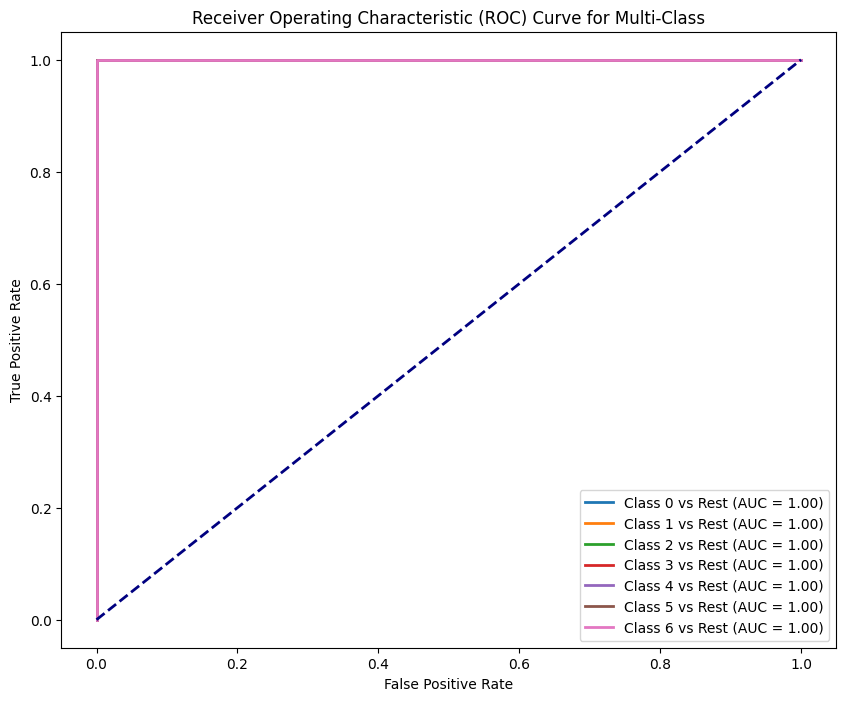

Overall AUC-ROC: 1.00


In [77]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Define the number of classes
num_classes = len(class_names)  # Adjust this as needed

# Binarize the test labels for multi-class ROC AUC
test_labels_binarized = label_binarize(test_labels, classes=range(num_classes))

# Predict probabilities for the test dataset
y_pred_prob = []
with torch.no_grad():
    for images, _ in test_loader:
        # Move images to the device (e.g., GPU if available)
        images = images.to(device)
        
        # Get model predictions and apply softmax if necessary
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        
        # Collect predictions for all batches
        y_pred_prob.append(probabilities.cpu().numpy())

# Concatenate predictions into a single array
y_pred_prob = np.concatenate(y_pred_prob, axis=0)

# Create a plot for the ROC curve
plt.figure(figsize=(10, 8))

# Calculate and plot ROC curve for each class
for i, class_label in enumerate(range(num_classes)):
    fpr, tpr, _ = roc_curve(test_labels_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} vs Rest (AUC = {roc_auc:.2f})')

# Plot the random classifier line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')
plt.show()

# Optionally, calculate the overall multi-class AUC-ROC
auc_roc = roc_auc_score(test_labels_binarized, y_pred_prob, multi_class='ovr')
print(f"Overall AUC-ROC: {auc_roc:.2f}")


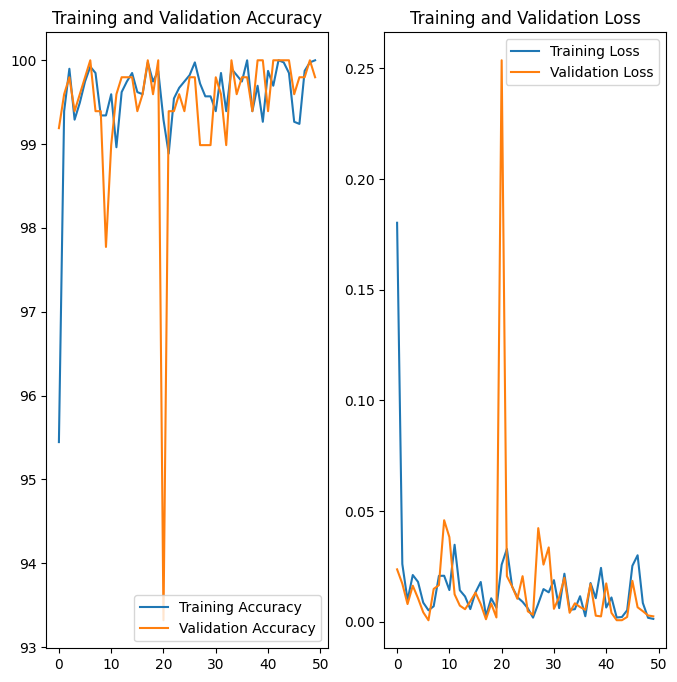

In [78]:
# Plotting
plt.figure(figsize=(8, 8))
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [41]:
import torch
import torchvision.models as models

# Assuming you have trained your model and it's called `model`
torch.save(model, '/kaggle/working/resnet_model.pth')


In [ ]:
import numpy as np
def predict_and_display(model, test_loader, class_names, batch_index, num_images=9):
    model.eval()  # Set model to evaluation mode
    plt.figure(figsize=(14, 14))
    
    # Iterate over the DataLoader to reach the desired batch
    for current_batch_index, (images_batch, labels_batch) in enumerate(test_loader):
        if current_batch_index == batch_index:  # Check if we've reached the desired batch
            for i in range(min(num_images, len(images_batch))):  # Ensure we don't exceed available images
                ax = plt.subplot(3, 3, i + 1)

                # Display the image (denormalizing for proper display)
                plt.imshow(images_batch[i].cpu().numpy().transpose((1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
                plt.axis("off")  # Hide axes

                # Move image to device and make predictions
                images_batch = images_batch.to(device)
                outputs = model(images_batch)

                # Get predicted class and confidence
                predicted_idx = torch.argmax(outputs[i]).item()
                confidence = torch.max(torch.softmax(outputs[i], dim=0)).item() * 100  # Convert to percentage

                predicted_class = class_names[predicted_idx]
                actual_class = class_names[labels_batch[i]]

                # Display the title with actual class, predicted class, and confidence
                plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence:.2f}%")
            plt.show()  # Show the images and predictions for the selected batch
            break  # Exit after processing the selected batch



In [ ]:
# Example usage: x
predict_and_display(model, test_loader, dataset.classes, batch_index=12)
